In [59]:
# import packages 
from skimage import io, transform
import numpy as np
import open3d as o3d
import copy
import napari
import time
import os

from skimage import morphology
from skimage.measure import label, regionprops, block_reduce
from scipy import stats, ndimage
import matplotlib.pyplot as plt
import sys

%matplotlib notebook

#gfp_filename = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/03_registered/Registered_C1-220523_NULLxEn-Gal4_1.tif"
#dsred_filename = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/03_registered/Registered_C2-220523_NULLxEn-Gal4_1.tif"

gfp_filename = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/03_registered/Registered_C1-220322_D6xEn-Gal4_1.tif"
dsred_filename = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/03_registered/Registered_C2-220322_D6xEn-Gal4_1.tif"


abdomen_mask_file = "../../data_2/References_and_masks/Reference_abdomen_mask_iso.tif"

image_gfp = io.imread(gfp_filename)
image_dsred = io.imread(dsred_filename)
image_mask = io.imread(abdomen_mask_file)

mask_dist = ndimage.distance_transform_cdt(image_mask)

#viewer = napari.view_image(image_dsred)

<IPython.core.display.Javascript object>


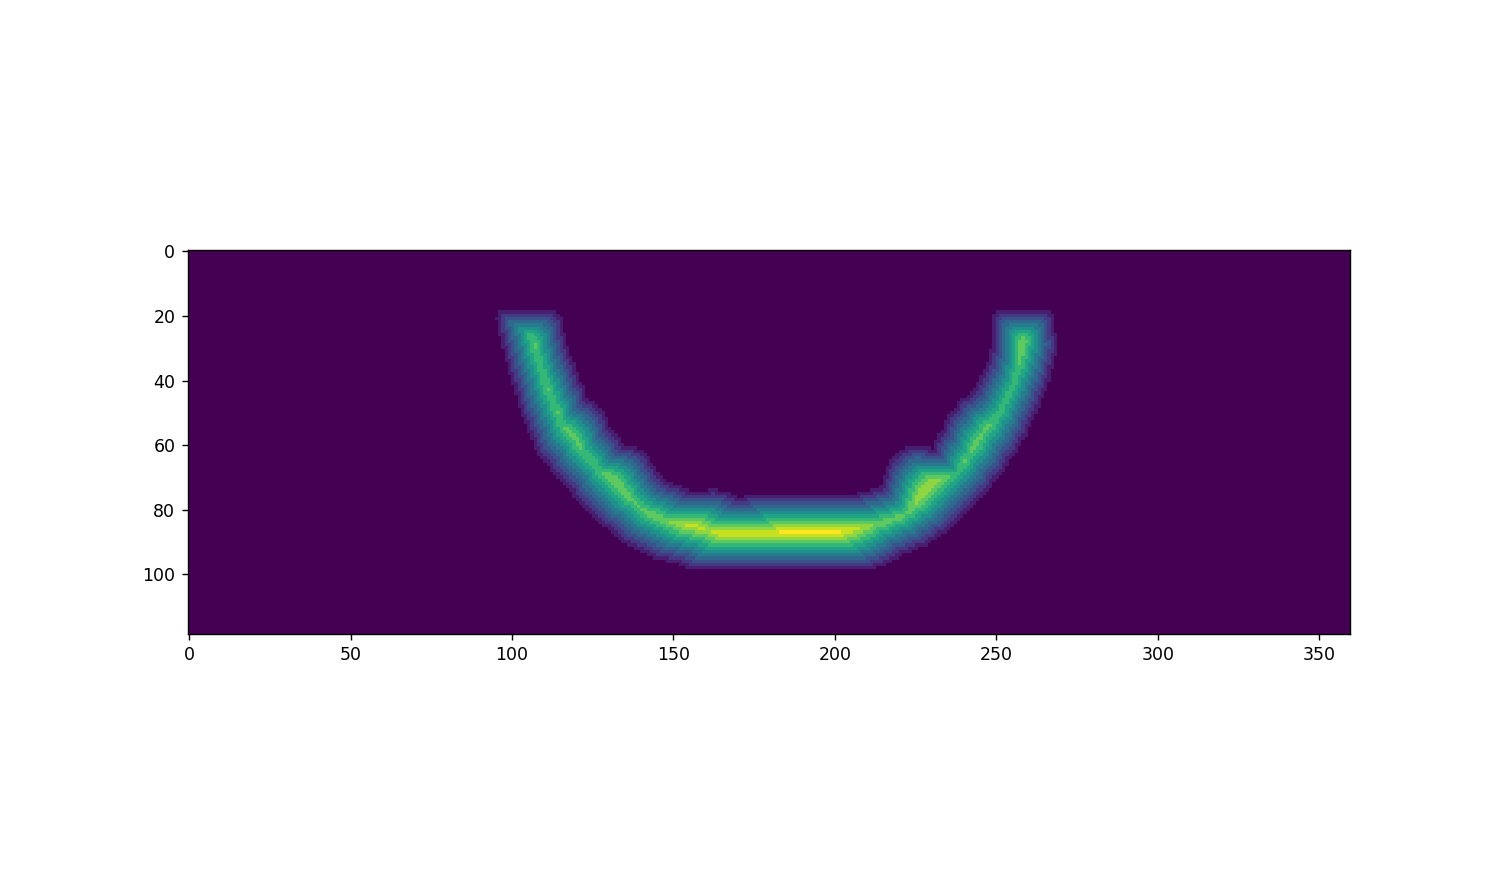

In [60]:
layer = 150
img_slice = (image_gfp+image_dsred)[:,:,layer]
img_slice = (image_gfp)[:,:,layer]
mask_slice = image_mask[:,:,layer]
mask_slice = ndimage.distance_transform_cdt(mask_slice)


fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(mask_slice)

In [61]:
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from scipy.signal import find_peaks
from scipy.interpolate import make_interp_spline
from scipy.ndimage import convolve1d

def moving_average(x, n = 3):
    convolved = convolve1d(x, np.ones(n), mode='constant')
    normalization = convolve1d(np.ones(len(x)), np.ones(n), mode = 'constant')
    normalized = convolved/normalization
    return normalized

# find starting points:
peaks, _ = find_peaks(mask_slice[20,:], distance = 20)

smooth_slice = gaussian(img_slice, 1, preserve_range=False)

if len(peaks)==2:
    start_x1 = peaks[0]
    start_y1 = 20
    start_x2 = peaks[1]
    start_y2 = 20
    center_x = 180
    center_y = np.argmax(smooth_slice[:,180])

<IPython.core.display.Javascript object>


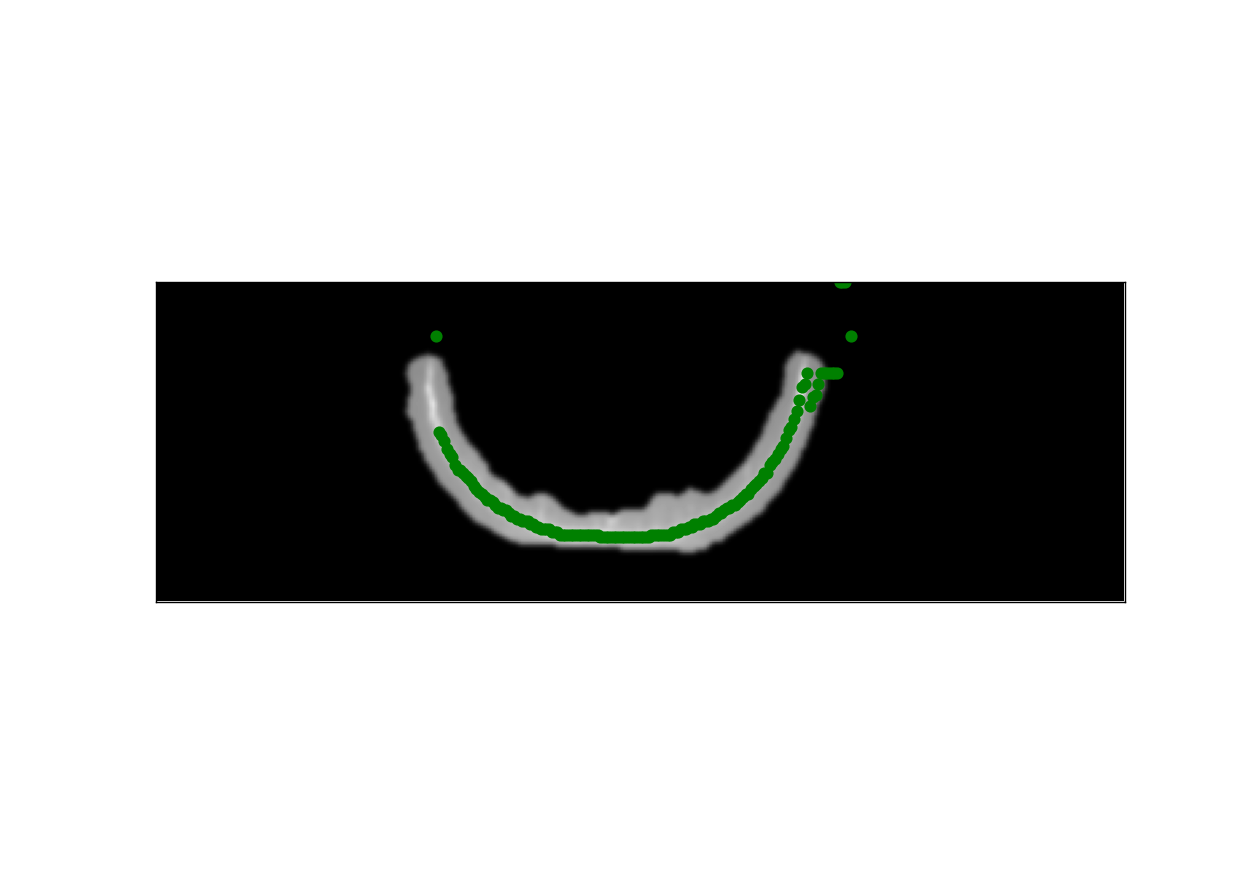

In [64]:
# use the maxima along z at each position x as starting points for the spline fitting:

x_o = np.linspace(start_x1, start_x2, int(np.abs(start_x2-start_x1)), dtype = int)
y_o = np.argmax(smooth_slice[:,x_o], axis = 0)

y_o[0] = 20
y_o[-1] = 20

x_i = moving_average(x_o, n = 5)
y_i = moving_average(y_o, n = 5)

y_i[0] = 20
y_i[-1] = 20

# resample the points to make the smapling more uniform and create the array containing the distance
# of each point from the first one along the curve.

distances = [0]
x = [x_i[0]]
y = [y_i[0]]
previous = 0
dist_from_previous = 0
minimum_dist = 4

for i in range(1, len(x_i)):
    dist_from_previous += ((x_i[i]-x_i[i-1])**2 + (y_i[i]-y_i[i-1])**2)**0.5
    if dist_from_previous > minimum_dist:
        distances.append(distances[-1]+dist_from_previous)
        x.append(x_i[i])
        y.append(y_i[i])
        dist_from_previous = 0
        
distances = np.array(distances)

# interpolate the points with a spline curve
spline = make_interp_spline(distances, np.c_[x, y], k=2)
x_new, y_new = spline(np.arange(0,int(max(distances)),1)).T

fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(smooth_slice, cmap=plt.cm.gray)
#ax.plot(x_i, y_i, 'or', lw=3)
ax.plot(x_o, y_o, 'og', lw=3)
#ax.plot(x, y, 'xb', lw=3)
#ax.plot(x_new, y_new, "xg", lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_slice.shape[1], img_slice.shape[0], 0])

plt.show()

In [47]:
round(3.9)

4

In [95]:
# Plot intensity profile:

profile = []

for i in range(len(x_new)):
    r = int(y_new[i])
    c = int(x_new[i])
    profile.append(np.mean(image_dsred[(r-1):(r+1),(c-1):(c+1), layer] ))
    
plt.plot(profile)

In [96]:
# Plot intensity profile:

profile = []

for i in range(len(x_new)):
    r = int(y_new[i])
    c = int(x_new[i])
    profile.append(image_dsred[r,c, layer])
    
plt.plot(profile)

In [38]:
# define functions for spline projection:

def moving_average(x, n = 3):
    convolved = convolve1d(x, np.ones(n), mode='constant')
    normalization = convolve1d(np.ones(len(x)), np.ones(n), mode = 'constant')
    normalized = convolved/normalization
    return normalized


def fit_spline_in_object_slice(mask_slice, image_slice, min_y = 20, center = 180):
    
    dist_slice = ndimage.distance_transform_cdt(mask_slice)
    smooth_slice = gaussian(image_slice, 1, preserve_range=False)
    
    # find starting points:
    peaks, _ = find_peaks(mask_slice[min_y,:], distance = 20)

    if len(peaks)==2:
        start_x1 = peaks[0]
        start_y1 = min_y
        start_x2 = peaks[1]
        start_y2 = min_y
    
    else:
        return None
    
    # use the maxima along y for each position x, as starting points
    # for the spline fitting:
    x_i = np.linspace(start_x1, start_x2, np.abs(start_x1-start_x2), dtype = int)
    y_i = np.argmax(smooth_slice[:,x_i], axis = 0)

    y_i[0] = min_y
    y_i[-1] = min_y

    x_i = moving_average(x_i, n = 5)
    y_i = moving_average(y_i, n = 5)

    y_i[0] = min_y
    y_i[-1] = min_y


    # resample the points to make the sampling more uniform and
    # create the array containing the distance of each point
    # from the first one along the curve.

    distances = [0]
    x = [x_i[0]]
    y = [y_i[0]]
    previous = 0
    dist_from_previous = 0
    minimum_dist = 4

    for i in range(1, len(x_i)):
        dist_from_previous += ((x_i[i]-x_i[i-1])**2 + (y_i[i]-y_i[i-1])**2)**0.5
        if dist_from_previous > minimum_dist:
            distances.append(distances[-1]+dist_from_previous)
            x.append(x_i[i])
            y.append(y_i[i])
            dist_from_previous = 0
            
    distances = np.array(distances)
    spline = make_interp_spline(distances, np.c_[x, y], k=2)
    x_new, y_new = spline(np.arange(0,int(max(distances)),1)).T
    
    return x_new, y_new


def brightness_along_curve_average(image, x, y, radius = 1):
    profile = []

    for i in range(len(x)):
        r = int(y[i])
        c = int(x[i])
        profile.append(np.mean(image[(r-radius):(r+radius),(c-radius):(c+radius)]))
    
    return np.array(profile)


def brightness_along_curve_perp_maxima(image, x, y, radius = 1):

    profile = []
    
    diff_x_fw = x[1:]-x[:-1]
    diff_y_fw = y[1:]-y[:-1]
    
    diff_x = np.concatenate([[0], diff_x_fw])+np.concatenate([diff_x_fw,[0]])
    diff_y = np.concatenate([[0], diff_y_fw])+np.concatenate([diff_y_fw,[0]])
    
    diff_x[1:-1] = diff_x[1:-1]/2 
    diff_y[1:-1] = diff_y[1:-1]/2 
    
    for i in range(len(x)):
        
        norm = (diff_x[i]**2+diff_y[i]**2)**0.5
        perp_dx = -diff_y[i]/norm
        perp_dy = diff_x[i]/norm
        
        cols = []
        rows = []
        for j in range(-radius, radius+1):
            cols.append( round(x[i]+perp_dx*j) )
            rows.append( round(y[i]+perp_dy*j) )
            
        profile.append(np.max(image[rows, cols]))

    return profile 


def spline_projection(image_stack_ref, image_stack_signal, image_mask, min_y = 20, center = 180):
    
    stack_shape = image_stack_ref.shape
    projected = np.zeros([stack_shape[2], stack_shape[2]])
    
    for layer in range(stack_shape[2]):
        image_slice  = image_stack_ref[:,:,layer]
        mask_slice = image_mask[:,:,layer]
        profile  = fit_spline_in_object_slice(mask_slice, image_slice, min_y, center)
        if profile is not None:
            profile_x, profile_y = profile
        else:
            continue
        
        projected_section = brightness_along_curve_average(image_stack_signal[:,:, layer], profile_x, profile_y, radius = 2)
        #projected_section = brightness_along_curve_perp_maxima(image_stack_signal[:,:, layer], profile_x, profile_y, radius = 2)
        
        # find center:
        profile_center = np.argmin(np.absolute(profile_x-center))
        
        projection_min = round(projected.shape[0]/2-profile_center)
        projection_max = projection_min+len(projected_section)
        
        projected[-layer, projection_min:projection_max] = projected_section
    
    return projected

from tifffile import imsave
projected = spline_projection(image_gfp, image_dsred, image_mask)
imsave(os.path.join("/home/ceolin/Documents/Test_fly_abdomens/220322_D6xEn-Gal4_1_Spline_average.tiff"), projected)

<IPython.core.display.Javascript object>


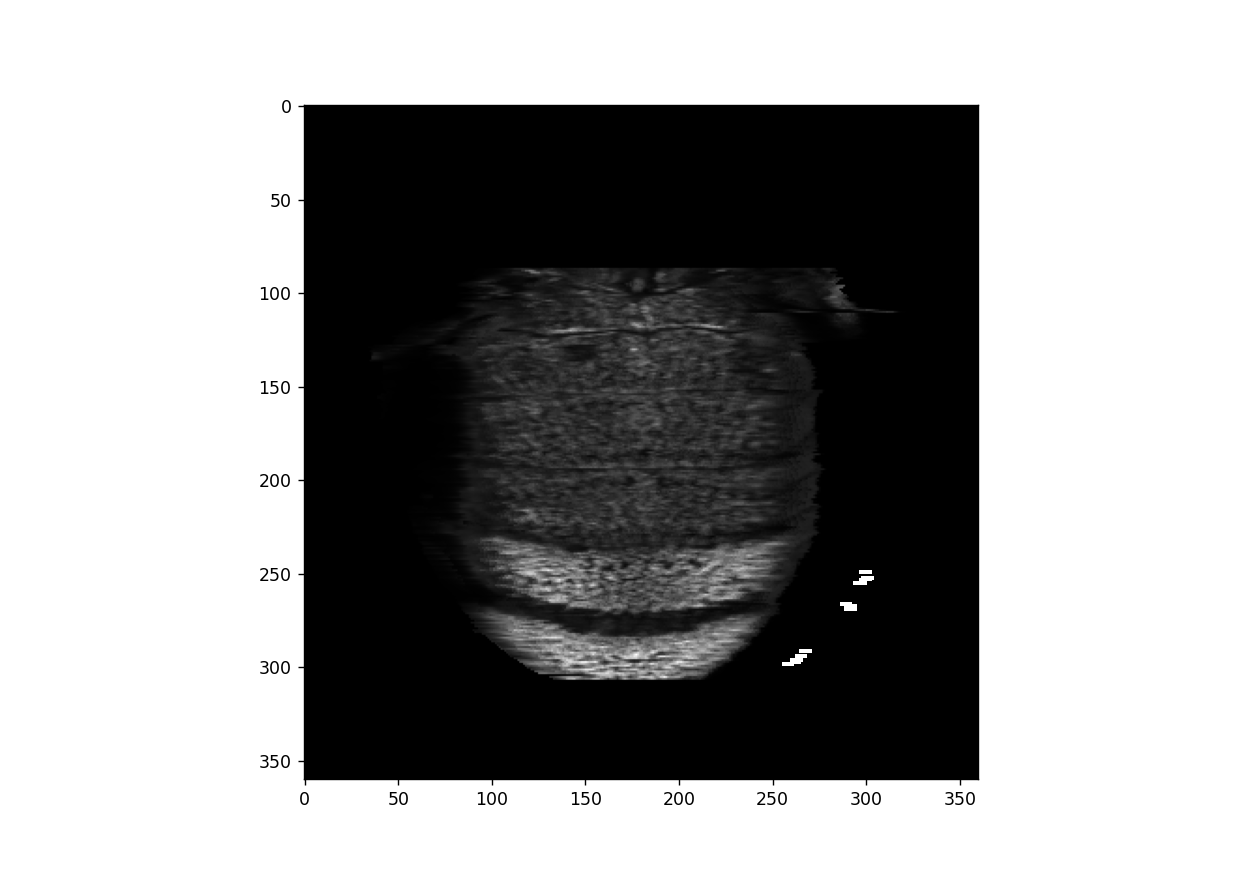

In [39]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(projected, cmap=plt.cm.gray)
plt.show()

<IPython.core.display.Javascript object>


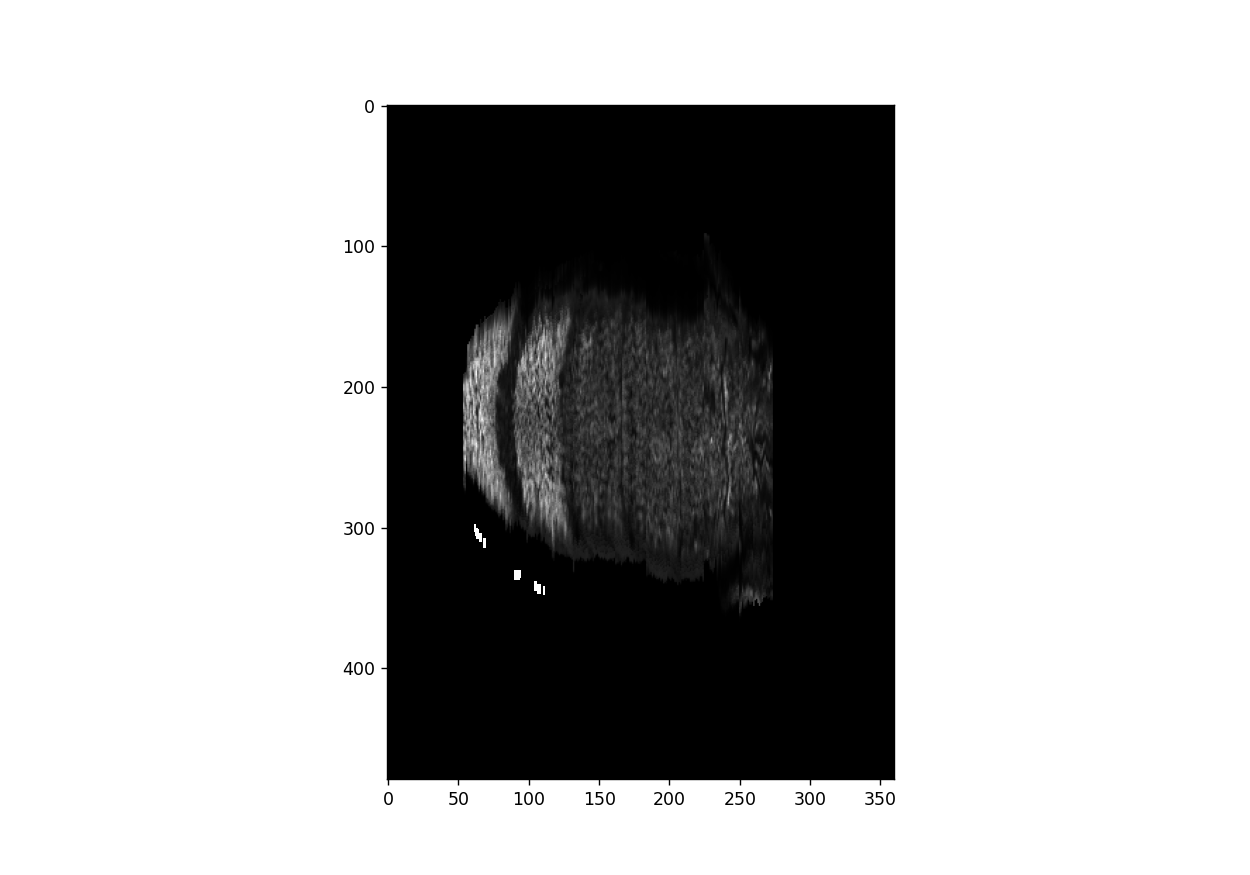

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(projected, cmap=plt.cm.gray)
plt.show()